### Importing Necessary Libraries

In [169]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.io import read_image

### Setting up CUDA and TensorBoard

In [170]:
# CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA available: {torch.cuda.is_available()}")

# TensorBoard
writer = SummaryWriter()
print(f"Writer: {writer}")

CUDA available: True
Writer: <torch.utils.tensorboard.writer.SummaryWriter object at 0x00000196DA976F20>


### Main Hyperparameters

In [171]:
image_base_size = 256
num_epochs = 20
batch_size = 10
learning_rate = 0.001

### Creating the Monkey Dataset and Loading in Training & Validation Data

In [172]:
class MonkeyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.number_samples = 0

        # Adding all monkeys to a list for indexing
        self.monkeys = []
        for dirname, _, filenames in os.walk(self.img_dir):
            for filename in filenames:
                self.number_samples += 1
                self.monkeys.append((
                    os.path.join(dirname, filename),
                    filename
                ))

    def __getitem__(self, index):
        monkey_path, monkey_filename = self.monkeys[index]

        monkey = read_image(monkey_path)  # This already converts to a tensor

        # Get monkey label from filename
        label = int(monkey_filename[1:2])  # Works since n0 to n9 all 2 characters
        
        # Apply the transforms
        if self.transform:
            tmonkey = self.transform(monkey)
        
        return tmonkey, label

    def __len__(self):
        return self.number_samples

    def get_species_map(self):
        # List of labels corresponding to monkey type
        return {i:j.strip() for i, j in zip(range(0, 10), self.img_labels.iloc[:, 2])}

### Initializing Datasets and Dataloaders

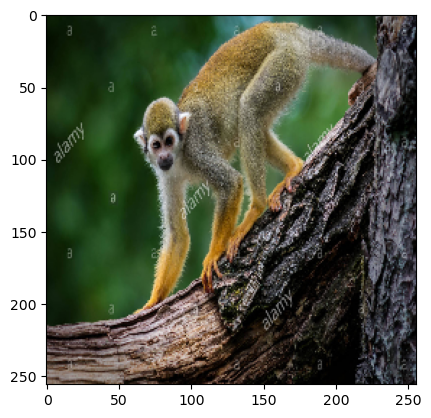

Batch shape: torch.Size([10, 3, 256, 256])
Image shape: torch.Size([3, 256, 256])


In [173]:
# Composition of transforms
composed = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize([image_base_size, image_base_size])  # Monkey images are not all square
])

# Training and validation datasets (different from dataloaders)
# Datasets gets passed into a dataloader
training_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/training/training",
    transform = composed
)

validation_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/validation/validation",
    transform = composed
)

# Dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

# Peeking into the dataloader to get an example batch (train_dataloader is an iterator)
monkey_batch, train_labels = next(iter(train_dataloader))

# Showing an example monkey
# https://stackoverflow.com/a/66641911
plt.imshow(monkey_batch[0].permute(1, 2, 0))
plt.show()

# Use CUDA
monkey_batch = monkey_batch.to(device)
train_labels = train_labels.to(device)

# [[[image_channel1, image_channel2, image_channel3], ...]], [label1, ...]
print(f"Batch shape: {monkey_batch.shape}")
print(f"Image shape: {monkey_batch[0].shape}")

species = training_data.get_species_map()

# Add batch of images to TensorBoard
writer.add_images("Example Batch", monkey_batch)

### Preloaded Model Parameters

In [174]:
use_saved = False
model_dir = "./models/"
model_path = "./models/m1673065399.pt"

### Defining the Convolutional Neural Network

In [175]:
class CNN(nn.Module):
    def __init__(self) -> None:
        # Note: https://discuss.pytorch.org/t/dataset-inheritance-does-not-require-super/92945/2
        super().__init__()

        # Classification learning
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        
        # Feature learning (regular NN part)
        self.full_con1 = nn.Linear(8*8*24, 1000)
        self.full_con2 = nn.Linear(1000, 100)
        self.full_con3 = nn.Linear(100, 10)
    
    def forward(self, x):
        # F.leaky_relu is a function, self.conv1 was from a class that called the function somewhere
        # Function takes in a tensor as input and outputs tensor
        s = self.pool(F.leaky_relu(self.conv1(x)))  
        s = self.pool(F.leaky_relu(self.conv2(s)))  
        s = self.pool(F.leaky_relu(self.conv3(s)))

        # Output of classification learning squashed down:  channels * image width * image height
        s = torch.reshape(s, [-1, 8*8*24])

        s = F.leaky_relu(self.full_con1(s))
        s = F.leaky_relu(self.full_con2(s))
        s = self.full_con3(s)  # The last activation function (softmax) is applied by loss function

        return s

### Initializing New CNN or Using Defined Model

In [176]:
model = CNN()

# Load saved
if use_saved:
    model.load_state_dict(torch.load(model_path))
    model.eval()

# Use CUDA
model = model.to(device)

# Add graph to TensorBoard
writer.add_graph(model, input_to_model=monkey_batch)

print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (full_con1): Linear(in_features=1536, out_features=1000, bias=True)
  (full_con2): Linear(in_features=1000, out_features=100, bias=True)
  (full_con3): Linear(in_features=100, out_features=10, bias=True)
)


### Optimizing and Training the CNN

In [177]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

it = 0

if not use_saved:
    # Training loop
    for epoch in range(num_epochs):
        correct = 0  # Gets reset each epoch
        sum_loss = 0

        for iteration, (_monkey_batch, _train_labels) in enumerate(train_dataloader):
            # Use CUDA
            _monkey_batch = _monkey_batch.to(device)
            _train_labels = _train_labels.to(device)

            # Forward pass
            # Note: model.forward() is the same as model()
            pred = model.forward(_monkey_batch)  # Returns torch.Size([batch_size, 10])
            size_batch = pred.shape[1]

            # Clearing accumulated gradients from optimizer
            optimizer.zero_grad()

            # Calculate loss and do backwards pass
            # Target is a value between 0 and C
            loss = loss_fn(pred, _train_labels)  # Notes for what gets passed here: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
            loss.backward()  # Calculates gradients for optimizer step function

            # Backpropagation
            optimizer.step()

            _, max_pred = torch.max(pred, 1)
            correct += sum((max_pred == _train_labels))  # Sum of boolean arrays

            writer.add_scalar("Loss/train Per Iteration", loss, it)

            sum_loss += loss
            it += 1

        avg_loss = sum_loss/len(train_dataloader)
        avg_acc = correct/len(training_data)

        # Add accuracy and loss to tensorboard (for epoch and iteration)
        writer.add_scalar("Avg Loss/train per Epoch", avg_loss, epoch)
        writer.add_scalar("Avg Accuracy/train per Epoch", avg_acc, epoch)
        print(f"Epoch: {epoch} Avg Loss: {avg_loss} Avg Accuracy: {avg_acc}")

Epoch: 0 Avg Loss: 2.168630838394165 Avg Accuracy: 0.2012750506401062
Epoch: 1 Avg Loss: 1.8063637018203735 Avg Accuracy: 0.3269580900669098
Epoch: 2 Avg Loss: 1.4947527647018433 Avg Accuracy: 0.46994534134864807
Epoch: 3 Avg Loss: 1.2682619094848633 Avg Accuracy: 0.561930775642395
Epoch: 4 Avg Loss: 1.0758472681045532 Avg Accuracy: 0.625683069229126


### Evaluating model accuracy with actual dataset

In [ ]:
# Don't want to mess with the model
with torch.no_grad():
    tot = 0
    right = 0

    # Calculating accuracy for validation photos with trained model
    for v_monkey_batch, v_train_labels in validation_dataloader:
        v_monkey_batch = v_monkey_batch.to(device)
        v_train_labels = v_train_labels.to(device)

        # Model output logits, what the CNN think the species is
        guess = model(v_monkey_batch)

        _, max_pred = torch.max(guess, 1)
        right += sum(max_pred == v_train_labels)

        # First pass, classification results of trained network for random batch
        if not tot:
            for i, img in enumerate(v_monkey_batch):
                writer.add_image(f"Monkey {i}: Actual: {species[v_train_labels[i].item()]}, Predicted: {species[max_pred[i].item()]}", img)

        tot += max_pred.shape[0]  # Batch size

print(f"Final Acc: {right/tot}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Final Acc: 0.2904411852359772


### Exporting Trained Model

In [ ]:
torch.save(model.state_dict(), os.path.join(model_dir, f"m{int(time.time())}.pt"))